<a href="https://colab.research.google.com/github/Buy-me-some-str/practice/blob/main/%D0%BE%D0%BF%D1%82%D0%B8%D0%BC%D0%B8%D0%B7%D0%B0%D1%82%D0%BE%D1%80%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import torch 
from torch import nn
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt

In [66]:
fashin_mnist = tf.keras.datasets.fashion_mnist

In [67]:
(X_train, y_train), (X_test, y_test) = fashin_mnist.load_data()
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).float()
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test).float()

In [68]:
import torchvision.datasets

MNIST_train = torchvision.datasets.MNIST('./', download = True, train = True)
MNIST_test = torchvision.datasets.MNIST('./', download = True, train = False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



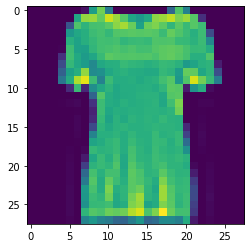

In [69]:
plt.imshow(X_train[10, :, :])

In [70]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([60000, 28, 28]) torch.Size([60000]) torch.Size([10000, 28, 28]) torch.Size([10000])


In [71]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
device

device(type='cuda', index=0)

In [72]:
y_new_train = torch.zeros(len(y_train), len(y_train.unique()))
y_new_train = y_new_train.long()
for i in range(0, len(y_train)):
    y_new_train[i, y_train[i].long()] = 1
y_new_test = torch.zeros(len(y_test), len(y_test.unique()))
for i in range(0, len(y_test)):
    y_new_test[i, y_test[i].long()] = 1


In [91]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
y_new_train = y_new_train.to(device).float()
y_new_test = y_new_test.to(device).float()
X_train.dtype
batch_size = 10

In [74]:
from torch.nn.modules.pooling import MaxPool2d
class NetFashionMNIST(nn.Module):
    def __init__(self):
        super (NetFashionMNIST, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 1,
                      out_channels = 16,
                      kernel_size = 5,
                      stride = 1,
                      padding = 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 16,
                         out_channels = 32,
                         kernel_size = 5,
                         stride = 1,
                         padding = 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Linear(32*7*7, 10)
        self.sm = nn.Softmax(dim=1)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    def predict(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x


In [75]:
model_0 = NetFashionMNIST()
model_0 = model_0.to(device)
history_optimizers_scores = []

In [76]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model_0.parameters(), lr = 0.001)
optimizer3 = torch.optim.Adagrad(model_0.parameters(), lr =0.001)
optimizer4 = torch.optim.RMSprop(model_0.parameters(), lr = 0.001)


In [77]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    #item() - из тензора делает число
    accuracy = (correct/len(y_pred))*100
    return accuracy

### Adam

In [159]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = NetFashionMNIST()
model_0 = model_0.to(device)
epochs = 10
loss_value1 = []
test_loss_value1 = []
for epoch in range(epochs):
    model_0.train()
    order = np.random.permutation(len(X_train))
    #print("Epoch", epoch, "start")
    for start_indexes in range(0, len(X_train), batch_size):
        optimizer1.zero_grad()
        batch_indexes = order[start_indexes:start_indexes+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_new_train[batch_indexes]
        predictions = model_0.forward(X_batch.reshape((batch_size, 1, 28, 28)))
        loss_value = loss_function(predictions, y_batch)
        loss_value.backward()
        optimizer1.step()
    model_0.eval()
    if epoch%1==0:
        with torch.inference_mode():
            y_test_pred_logits = model_0.forward(X_test.reshape((10000, 1, 28, 28)))
            y_test_pred_probs = torch.softmax(y_test_pred_logits, dim=1)
            y_pred = torch.argmax(y_test_pred_probs, dim=1)
            #acc = accuracy_fn(y_true=y_test, y_pred=y_pred)
            test_loss_value1.append(loss_value)
            #print(f"Epoch{epoch} | Accuracy {acc:.5f}")

### SGD

In [118]:
model_2 = NetFashionMNIST()
optimizer2 = torch.optim.SGD(model_2.parameters(), lr = 0.001)
model_2.to(device)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 10
loss_value2 = []
test_loss_value2 = []
for epoch in range(epochs):
    model_2.train()
    order = np.random.permutation(len(X_train))
    #print("Epoch", epoch, "start")
    for start_indexes in range(0, len(X_train), batch_size):
        optimizer2.zero_grad()
        batch_indexes = order[start_indexes:start_indexes+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_new_train[batch_indexes]
        predictions = model_2.forward(X_batch.reshape((batch_size, 1, 28, 28)))
        loss_value = loss_function(predictions, y_batch)
        loss_value.backward()
        optimizer2.step()
    model_2.eval()
    if epoch%1==0:
        with torch.inference_mode():
            y_test_pred_logits = model_2.forward(X_test.reshape((10000, 1, 28, 28)))
            y_test_pred_probs = torch.softmax(y_test_pred_logits, dim=1)
            y_pred = torch.argmax(y_test_pred_probs, dim=1)
            #acc = accuracy_fn(y_true=y_test,y_pred=y_pred)
            test_loss_value2.append(loss_value)

### Adagrad

In [141]:
model_3 = NetFashionMNIST()
optimizer3 = torch.optim.Adagrad(model_2.parameters(), lr = 0.001)
model_3.to(device)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 10
loss_value3 = []
test_loss_value3 = []
for epoch in range(epochs):
    model_3.train()
    order = np.random.permutation(len(X_train))
    #print("Epoch", epoch, "start")
    for start_indexes in range(0, len(X_train), batch_size):
        optimizer3.zero_grad()
        batch_indexes = order[start_indexes:start_indexes+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_new_train[batch_indexes]
        predictions = model_3.forward(X_batch.reshape((batch_size, 1, 28, 28)))
        loss_value = loss_function(predictions, y_batch)
        loss_value.backward()
        optimizer3.step()
    model_3.eval()
    if epoch%1==0:
        with torch.inference_mode():
            y_test_pred_logits = model_3.forward(X_test.reshape((10000, 1, 28, 28)))
            y_test_pred_probs = torch.softmax(y_test_pred_logits, dim=1)
            y_pred = torch.argmax(y_test_pred_probs, dim=1)
            acc = accuracy_fn(y_true=y_test,
                              y_pred=y_pred)
            test_loss_value3.append(loss_value)

### RMSprop

In [161]:
optimizer4 = torch.optim.RMSprop(model_0.parameters(), lr = 0.001)
model_4 = NetFashionMNIST()
model_4.to(device)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 10
loss_value4 = []
test_loss_value4 = []
for epoch in range(epochs):
    model_4.train()
    order = np.random.permutation(len(X_train))
    #print("Epoch", epoch, "start")
    for start_indexes in range(0, len(X_train), batch_size):
        optimizer4.zero_grad()
        batch_indexes = order[start_indexes:start_indexes+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_new_train[batch_indexes]
        predictions = model_4.forward(X_batch.reshape((batch_size, 1, 28, 28)))
        loss_value = loss_function(predictions, y_batch)
        loss_value.backward()
        optimizer4.step()
    model_4.eval()
    if epoch%1==0:
        with torch.inference_mode():
            y_test_pred_logits = model_4.forward(X_test.reshape((10000, 1, 28, 28)))
            y_test_pred_probs = torch.softmax(y_test_pred_logits, dim=1)
            y_pred = torch.argmax(y_test_pred_probs, dim=1)
            #acc = accuracy_fn(y_true=y_test, y_pred=y_pred)
            test_loss_value4.append(loss_value)

### графики тестов

In [166]:
for i in range(len(test_loss_value2)):
    test_loss_value2[i] =test_loss_value2[i].to("cpu").detach()
    test_loss_value3[i] =test_loss_value3[i].to("cpu").detach()
    test_loss_value1[i] =test_loss_value1[i].to("cpu").detach()
    test_loss_value4[i] =test_loss_value4[i].to("cpu").detach()


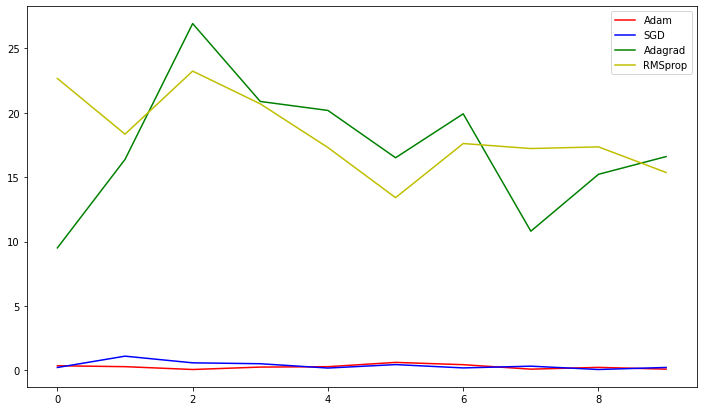

In [167]:
plt.figure(figsize = (12, 7))
x = np.arange(len(test_loss_value1))
plt.plot(x, np.array(test_loss_value1), c ="r", label = "Adam")
plt.plot(x, np.array(test_loss_value2), c ="b", label = "SGD")
plt.plot(x, np.array(test_loss_value3), c ="g", label = "Adagrad")
plt.plot(x, np.array(test_loss_value4), c="y", label = "RMSprop")
plt.legend()
